In [60]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal
from scipy.interpolate import interp2d
from src.cp_hw2 import *
from tqdm import tqdm

# Capture and refocus your own lightfield

## Refocusing an unstructured lightfield

In [61]:
def read_video_frames(video_path, skip_interval, skip_pixel):
    """
    Reads video from the given path and selects frames at the specified interval,
    subsampling pixels by the given skip_pixel factor.
    
    Args:
    video_path (str): Path to the video file.
    skip_interval (int): Interval at which to select frames.
    skip_pixel (int): Factor by which to subsample pixels.
    
    Returns:
    np.array: Array of selected video frames.
    """
    video_capture = cv2.VideoCapture(video_path)
    selected_frames = []
    frame_count = 0
    
    while True:
        success, frame = video_capture.read()
        if not success:
            break
        if frame_count % skip_interval == 0:
            # Subsample pixels and convert BGR to RGB
            frame = frame[::skip_pixel, ::skip_pixel, ::-1]
            selected_frames.append(frame)
        frame_count += 1
    
    video_capture.release()
    return np.array(selected_frames).transpose(1, 2, 3, 0)

# Usage
video_path = 'data/DSC_0099.MOV'
skip_interval = 10  # Select one frame every 10 frames
num_skip_pixel = 2  # Subsample every 4 pixels

# Read video and select frames
video_frames = read_video_frames(video_path, skip_interval, num_skip_pixel)


In [62]:
video_frames.shape

(540, 960, 3, 78)

In [63]:
def linearize_image(C_nonlinear):
    """
    Linearizes an image by applying gamma correction.
    
    Args:
    C_nonlinear (np.array): Non-linear image data.
    
    Returns:
    np.array: Linearized image data.
    """
    # Using numpy's where function to vectorize the conditional operation
    return np.where(
        C_nonlinear <= 0.0404482,
        C_nonlinear / 12.92,
        ((C_nonlinear + 0.055) / 1.055) ** 2.4
    )

def compute_luminance(img):
    """
    Computes the luminance channel of an image.
    
    Args:
    img (np.array): Image data.
    
    Returns:
    np.array: Luminance channel of the image.
    """
    # Ensure the image has a fourth dimension if it's a single image
    if len(img.shape) == 3:
        img = np.expand_dims(img, axis=3)
    
    # Apply linearization to the image
    I_linear = linearize_image(img)
    
    # Initialize an array for XYZ conversion with the same shape as the linear image
    I_XYZ = np.zeros(I_linear.shape)
    
    # Convert each frame to XYZ color space
    for foc_im in range(I_linear.shape[-1]):
        I_XYZ[:, :, :, foc_im] = lRGB2XYZ(I_linear[:, :, :, foc_im])
    
    # Extract the Y channel, which represents luminance
    I_luminance = I_XYZ[:, :, 1, :]  # take just the Y channel for relative luminance
    
    return I_luminance


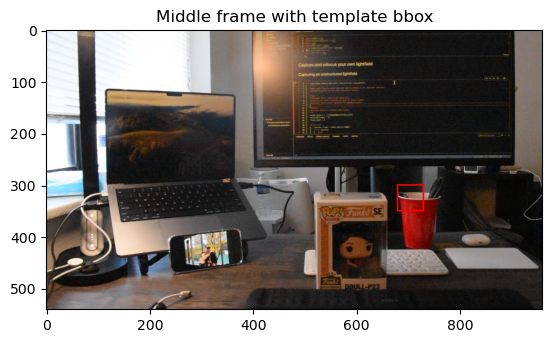

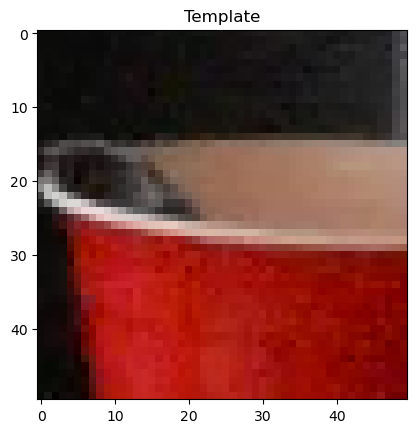

In [86]:
# # For Fanko
# w = 50
# h = 50
# left_top = [330, 520]
# bbox = (np.array([left_top[0], left_top[1], left_top[0] + h, left_top[1] + w])).astype('int')

# # For photo
# w = 50
# h = 50
# left_top = [410, 290]
# bbox = (np.array([left_top[0], left_top[1], left_top[0] + h, left_top[1] + w])).astype('int')

# For cup
w = 50
h = 50
left_top = [300, 680]
bbox = (np.array([left_top[0], left_top[1], left_top[0] + h, left_top[1] + w])).astype('int')

img_mid_frame = video_frames[:,:,:,video_frames.shape[3]//2].copy()

plt.imshow(cv2.rectangle(img_mid_frame.copy(),(bbox[1],bbox[0]), (bbox[3], bbox[2]), (255,0,0), 2))
plt.title('Middle frame with template bbox')
plt.show()

template = img_mid_frame[bbox[0] :  bbox[2] , bbox[1] : bbox[3]]
plt.imshow(template)
plt.title('Template')
plt.show()

# template = np.mean(template,2)
# mid_im = np.mean(mid_im,2)
template = compute_luminance(template)
img_mid_frame = compute_luminance(img_mid_frame)

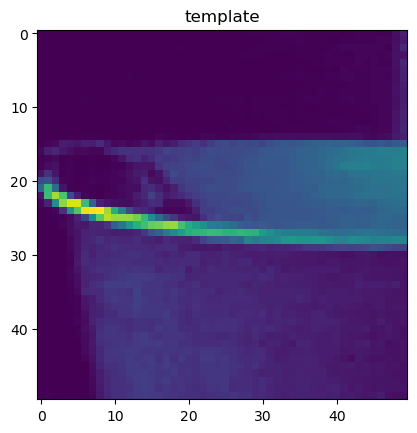

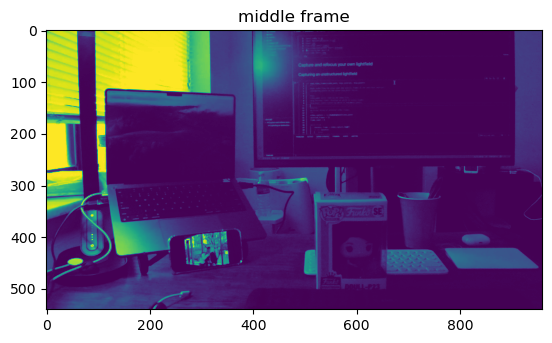

(50, 50, 1)
(540, 960, 1)


In [87]:
plt.imshow(template)
plt.title('template')
plt.show()

plt.imshow(img_mid_frame)
plt.title('middle frame')
plt.show()

print(template.shape)
print(img_mid_frame.shape)

In [94]:
def compute_norm_xcorr(img, template, bbox):
    """
    Compute normalized cross-correlation between an image and a template.
    
    Args:
    img (np.array): The image to search within.
    template (np.array): The template image to search for.
    bbox (tuple): A bounding box defined as (top, left, bottom, right).
    
    Returns:
    np.array: Normalized cross-correlation coefficients.
    """
    d1 = np.sum((template - template.mean())**2)
    norm_xcorr = np.zeros(img.shape)

    bbox_center = [(bbox[0] + bbox[2])/2, (bbox[1]+bbox[3])/2]
    bbox_size = np.array(template.shape) * 2
    count = 0

    for i in range(img.shape[0]) : 

        if np.abs(i - bbox_center[0]) > bbox_size[0] : continue

        for j in range(img.shape[1]) :

            if np.abs(j - bbox_center[1]) > bbox_size[1] : continue

            if img[i:i+template.shape[0], j:j+template.shape[1]].shape != template.shape : continue

            count += 1
            num = np.sum(img[i:i+template.shape[0], j:j+template.shape[1]] * template)
            I_bar = img[i:i+template.shape[0], j:j+template.shape[1]] / img[i:i+template.shape[0], j:j+template.shape[1]].sum()
            d2 = np.sum((img[i:i+template.shape[0], j:j+template.shape[1]] - I_bar) ** 2)
            norm_xcorr[i,j] = num / np.sqrt(d1*d2)
            
    return norm_xcorr

def compute_shift(norm_xcorr, bbox):
    """
    Compute the shift from the center of the bounding box to the point of highest correlation.
    
    Args:
    norm_xcorr (np.array): Normalized cross-correlation coefficients.
    bbox (tuple): A bounding box defined as (top, left, bottom, right).
    
    Returns:
    tuple: The shift in x and y coordinates.
    """
    # Find the index of the maximum correlation coefficient
    y, x = np.unravel_index(np.argmax(norm_xcorr), norm_xcorr.shape)
    shift_x = x - bbox[1]  # Calculate shift in x
    shift_y = y - bbox[0]  # Calculate shift in y
    return shift_x, shift_y

def display_correspondance(norm_xcorr, frame=None):
    """
    Display the correspondence of the normalized cross-correlation on the image.
    
    Args:
    norm_xcorr (np.array): Normalized cross-correlation coefficients.
    frame (np.array): The image frame to display the correspondence on.
    """
    # Find the index of the maximum correlation coefficient
    y, x = np.unravel_index(np.argmax(norm_xcorr), norm_xcorr.shape)
    plt.imshow(norm_xcorr**4)  # Enhance visibility by raising to the power of 4
    plt.show()

    if frame is not None:
        plt.imshow(frame)
        plt.scatter(x, y, 50, 'r')  # Mark the correspondence with a red dot
        plt.show()

# # Sanity check: compute shift between template and img_mid_frame -> should be (0,0)
# norm_xcorr = compute_norm_xcorr(img_mid_frame[:,:,0], template[:,:,0], bbox)
# display_correspondance(norm_xcorr, img_mid_frame)

# print('Shift:', compute_shift(norm_xcorr, bbox))

In [89]:
# frame interpolator
L_interp = []
for i in range(video_frames.shape[3]) :
        temp = []
        temp.append(interp2d(np.arange(video_frames.shape[1]),np.arange(video_frames.shape[0]),video_frames[:,:,0,i]))
        temp.append(interp2d(np.arange(video_frames.shape[1]),np.arange(video_frames.shape[0]),video_frames[:,:,1,i]))
        temp.append(interp2d(np.arange(video_frames.shape[1]),np.arange(video_frames.shape[0]),video_frames[:,:,2,i]))
        L_interp.append(temp)

In [90]:
frames_shifted = np.zeros(video_frames.shape)
shift_array = []
frames_luminance = compute_luminance(video_frames)
frames_combined = np.zeros(video_frames[:,:,:,0].shape)

# calculate shift
print('Compute shift, shift and combine frames')
for frame_idx in tqdm(range(video_frames.shape[3])) : 
    norm_xcorr = compute_norm_xcorr(frames_luminance[:,:,frame_idx], template[:,:,0], bbox)
    # display_correspondance(norm_xcorr,video_frames[:,:,:,frame_idx])
    shift_array.append(compute_shift(norm_xcorr, bbox))
    shift_x, shift_y = compute_shift(norm_xcorr, bbox)

    temp = np.zeros(video_frames[:,:,:,0].shape)
    cur_fun = L_interp[frame_idx]
    temp[:,:,0] = cur_fun[0](np.arange(video_frames.shape[1])+shift_x, np.arange(video_frames.shape[0])+shift_y)
    temp[:,:,1] = cur_fun[1](np.arange(video_frames.shape[1])+shift_x, np.arange(video_frames.shape[0])+shift_y)
    temp[:,:,2] = cur_fun[2](np.arange(video_frames.shape[1])+shift_x, np.arange(video_frames.shape[0])+shift_y)
    frames_shifted[:,:,:,frame_idx] = temp.copy() 
    
    frames_combined += temp.copy() / video_frames.shape[3]


Compute shift, shift and combine frames


100%|██████████| 78/78 [02:06<00:00,  1.62s/it]


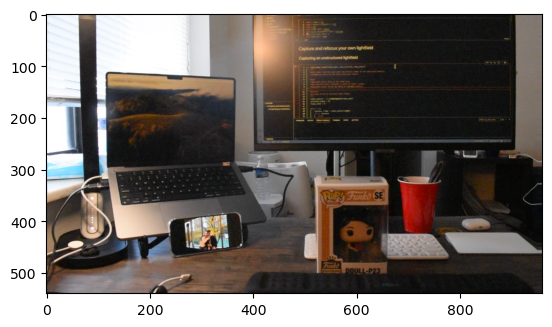

In [91]:
plt.imshow(frames_shifted[...,40].astype('int'))

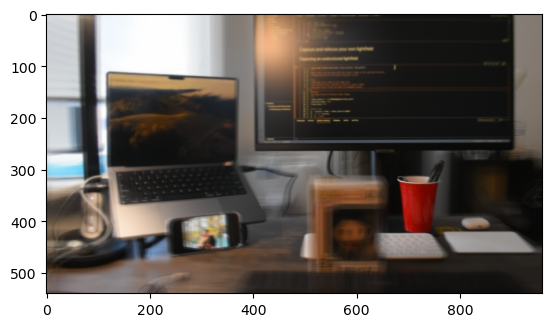

In [92]:
plt.imshow(frames_combined.astype('int'))


In [93]:
cv2.imwrite('results/cup_focused.png',frames_combined[...,::-1])


True